### This notebook is optionally accelerated with a GPU runtime.
### If you would like to use this acceleration, please select the menu option "Runtime" -> "Change runtime type", select "Hardware Accelerator" -> "GPU" and click "SAVE"

----------------------------------------------------------------------

# MiDaS

*Author: Intel ISL*

**MiDaS models for computing relative depth from a single image.**

<img src="https://pytorch.org/assets/images/midas_samples.png" alt="alt" width="50%"/>


### Model Description

[MiDaS](https://arxiv.org/abs/1907.01341) computes relative inverse depth from a single image. The repository provides multiple models that cover different use cases ranging from a small, high-speed model to a very large model that provide the highest accuracy. The models have been trained on 10 distinct datasets using
multi-objective optimization to ensure high quality on a wide range of inputs.

### Dependencies

MiDaS depends on [timm](https://github.com/rwightman/pytorch-image-models). Install with

In [1]:
pip install timm

     |████████████████████████████████| 431 kB 27.9 MB/s 


### Example Usage

Download an image from the PyTorch homepage

In [24]:
import cv2
import torch
import urllib.request

import matplotlib.pyplot as plt

url, filename = ("https://github.com/pytorch/hub/raw/master/images/dog.jpg", "dog.jpg")
urllib.request.urlretrieve(url, filename)

('dog.jpg', <http.client.HTTPMessage at 0x7f0dcc48c910>)

Load a model (see [https://github.com/intel-isl/MiDaS/#Accuracy](https://github.com/intel-isl/MiDaS/#Accuracy) for an overview)

In [14]:
#model_type = "DPT_Large"     # MiDaS v3 - Large     (highest accuracy, slowest inference speed)
#model_type = "DPT_Hybrid"   # MiDaS v3 - Hybrid    (medium accuracy, medium inference speed)
model_type = "MiDaS_small"  # MiDaS v2.1 - Small   (lowest accuracy, highest inference speed)

midas = torch.hub.load("intel-isl/MiDaS", model_type)

Using cache found in /root/.cache/torch/hub/intel-isl_MiDaS_master
Downloading: "https://github.com/rwightman/gen-efficientnet-pytorch/archive/master.zip" to /root/.cache/torch/hub/master.zip


Loading weights:  None


Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-weights/tf_efficientnet_lite3-b733e338.pth" to /root/.cache/torch/hub/checkpoints/tf_efficientnet_lite3-b733e338.pth
Downloading: "https://github.com/intel-isl/MiDaS/releases/download/v2_1/model-small-70d6b9c8.pt" to /root/.cache/torch/hub/checkpoints/model-small-70d6b9c8.pt


  0%|          | 0.00/81.8M [00:00<?, ?B/s]

Move model to GPU if available

In [25]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
midas.to(device)
midas.eval()
()

()

In [26]:
for (name, layer) in midas._modules.items():
    #iteration over outer layers
    print((name))

pretrained
scratch


In [27]:
from torchvision import models
from torchsummary import summary

summary(midas, (3, 384, 480))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
         ZeroPad2d-1          [-1, 3, 385, 481]               0
  Conv2dSameExport-2         [-1, 32, 192, 240]             864
       BatchNorm2d-3         [-1, 32, 192, 240]              64
             ReLU6-4         [-1, 32, 192, 240]               0
            Conv2d-5         [-1, 32, 192, 240]             288
       BatchNorm2d-6         [-1, 32, 192, 240]              64
             ReLU6-7         [-1, 32, 192, 240]               0
          Identity-8         [-1, 32, 192, 240]               0
            Conv2d-9         [-1, 24, 192, 240]             768
      BatchNorm2d-10         [-1, 24, 192, 240]              48
         Identity-11         [-1, 24, 192, 240]               0
DepthwiseSeparableConv-12         [-1, 24, 192, 240]               0
           Conv2d-13        [-1, 144, 192, 240]           3,456
      BatchNorm2d-14        [-1, 1

Load transforms to resize and normalize the image for large or small model

In [28]:
midas_transforms = torch.hub.load("intel-isl/MiDaS", "transforms")

if model_type == "DPT_Large" or model_type == "DPT_Hybrid":
    transform = midas_transforms.dpt_transform
else:
    transform = midas_transforms.small_transform

Using cache found in /root/.cache/torch/hub/intel-isl_MiDaS_master


Load image and apply transforms

In [19]:
img = cv2.imread(filename)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

input_batch = transform(img).to(device)

In [20]:
input_batch.shape

torch.Size([1, 3, 192, 256])

Predict and resize to original resolution

In [21]:
with torch.no_grad():
    prediction = midas(input_batch)

    prediction = torch.nn.functional.interpolate(
        prediction.unsqueeze(1),
        size=img.shape[:2],
        mode="bicubic",
        align_corners=False,
    ).squeeze()

output = prediction.cpu().numpy()

Show result

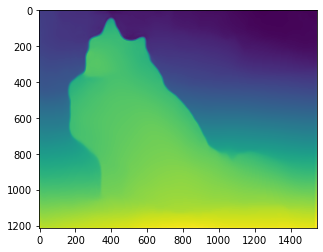

In [22]:
plt.imshow(output)
# plt.show()

Let's try to modify the model to include partial depth informations

In [30]:
#First, let's fix the pretrained values :
for parameter in midas.parameters(): 
    parameter.requires_grad=False

In [57]:
import torch.nn as nn
class MyModel(nn.Module):
    def __init__(self):
        super(MyModel, self).__init__()
        self.md = midas
        self.fcomb = nn.Conv2d(2,1,(20,20))
        self.ReLU=nn.ReLU()
    def forward(self, x, y):
        x1 = self.md(x)
        x2 = self.fcomb(torch.cat((x1.unsqueeze(1),y.unsqueeze(1)),1))
        x3 = self.ReLU(x2)
        return x2


In [51]:
import random
x=input_batch
res=midas(input_batch)
y=torch.zeros_like(res)
lx,ly=res.shape[1],res.shape[2]
for _ in range(180):
  i,j=random.randint(0,lx-1),random.randint(0,ly-1)
  y[0,i,j]=res[0,i,j]


In [59]:
model=MyModel()
model.to(device)
model.eval()
res=model(x,y)

tensor([[[[-205.8777, -209.4063, -200.3698,  ...,  -75.9047,  -76.5365,
            -76.7062],
          [-205.9474, -208.8449, -201.3086,  ...,  -75.2680,  -76.0571,
            -76.2739],
          [-193.5804, -206.8413, -209.4680,  ...,  -75.4426,  -75.9395,
            -76.2922],
          ...,
          [-760.2878, -784.2225, -721.0006,  ..., -881.4102, -823.6840,
           -859.8683],
          [-754.3086, -753.3676, -788.0999,  ..., -842.2870, -835.6967,
           -838.7532],
          [-779.3392, -768.6890, -768.2100,  ..., -801.1179, -807.8602,
           -802.6893]]]], device='cuda:0', grad_fn=<AddBackward0>)